In [31]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



In [1]:
from IPython.display import Image

import numpy as np
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
ROOT_DIR = "/Users/Tim/data/tcga_gbm"
METADATA_PATH = os.path.join(ROOT_DIR, "metadata", "all_non_background", "metadata.csv")
EMB_PATH = os.path.join(ROOT_DIR, "logs", "stratified_all_non_background_random_crop_20190125-164121", "agg_embeddings.pickle")
ALL_EMB_PATH = os.path.join(ROOT_DIR, "logs", "stratified_all_non_background_random_crop_20190125-164121", "embeddings.pickle")

In [3]:
metadata = pd.read_csv(METADATA_PATH)
case2label = metadata.groupby("case_id")["label"].first()

In [4]:
def load_embeddings(file_path):
    with open(file_path, "rb") as f:
        return pickle.load(f)

In [5]:
def create_X_y(file_path, split_name):
    embeddings = load_embeddings(file_path)
    embeddings = embeddings[split_name]
    df = {}
    y = np.zeros(len(embeddings))
    i = 0
    for case_id, vals in embeddings.items():
        df[case_id] = vals["mean"]
        y[i] = case2label[case_id]
        i += 1
    
    X = pd.DataFrame.from_dict(df, orient="index")
    return X, y

In [6]:
def create_X_y_full_embeddings(file_path, split_name):
    with open(file_path, "rb") as f:
        embeddings = pickle.load(f)
    
    embeddings_split = embeddings[split_name]
    labels = []
    case_embs = []
    for case_id, case_embeddings in embeddings_split.items():
        label = case2label[case_id]
        for _, emb in case_embeddings:
            labels.append(label)
            case_embs.append(emb)
    
    X = pd.DataFrame(np.array(case_embs))
    y = np.array(labels)
    return X, y

# MSE Loss

In [13]:
X_train, y_train = create_X_y(EMB_PATH, "train")
X_val, y_val = create_X_y(EMB_PATH, "val")
X_test, y_test = create_X_y(EMB_PATH, "test")
X, y = pd.concat([X_train, X_val]), np.concatenate([y_train, y_val])

In [14]:
X_train_full, y_train_full = create_X_y_full_embeddings(ALL_EMB_PATH, "train")
X_val_full, y_val_full = create_X_y_full_embeddings(ALL_EMB_PATH, "val")
X_test_full, y_test_full = create_X_y_full_embeddings(ALL_EMB_PATH, "test")
X_full, y_full = pd.concat([X_train_full, X_val_full]), np.concatenate([y_train_full, y_val_full])

## Dataset details

In [15]:
print("Number of patients in training set: {} ({} good; {} poor)".format(len(X), np.sum(y==1), np.sum(y==0)))
print("Number of patients in test set: {} ({} good; {} poor)".format(len(X_test), np.sum(y_test==1), np.sum(y_test==0)))

Number of patients in training set: 69 (37 good; 32 poor)
Number of patients in test set: 18 (10 good; 8 poor)


Note: We have less than 94 patients in total because we only selected whole-slide images from the location TOP and some patients did not have a TOP slide

## Predict poor/good survival

In [7]:
def run_classifier(X_train, y_train, X_test, y_test, clf, clf_name):
    clf.fit(X_train, y_train)
    train_acc = clf.score(X_train, y_train)
    test_acc = clf.score(X_test, y_test)
    print("{}:".format(clf_name))
    print("Training set accuracy: {:.2f} %".format(100*train_acc))
    print("Test set accuracy: {:.2f} %".format(100*test_acc))
    return clf

In [17]:
run_classifier(X, y, X_test, y_test, LogisticRegression(random_state=0, solver='lbfgs'), "Logistic Regression")

Logistic Regression:
Training set accuracy: 73.91 %
Test set accuracy: 38.89 %


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [18]:
run_classifier(X, y, X_test, y_test, RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0), "Random Forest")

Random Forest:
Training set accuracy: 85.51 %
Test set accuracy: 38.89 %


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [19]:
lda = run_classifier(X, y, X_test, y_test, LinearDiscriminantAnalysis(solver="svd"), "Linear Discriminant Analysis")

Linear Discriminant Analysis:
Training set accuracy: 94.20 %
Test set accuracy: 55.56 %


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [28]:
lda.coef_.shape
coef = lda.coef_.reshape((1024,))
outpath = os.path.join(ROOT_DIR, "stratified_all_non_background_random_crop_20190125-164121", "coefficients.pickle")
with open(outpath, "wb") as f:
    pickle.dump({"feature_importances": coef}, f)

Only the LDA classifier achieves a better than random performance on the test dataset. However, all classifiers get reasonable performance on the training dataset which could indicate that our classifiers overfit or that our learned features do not generalize well to unseen data.

Since the accuracy scores for the given models are not very promising so far I have not investigated other measures such as F1-score or precision-recall curves and instead tried to think of ways to improve our feature extractor.

## Visualisation

In [16]:
def visualise_reduced(X, y, reducer, alpha=0.8, title=None, filename=None, legend=True):
    plt.figure()
    X_r = reducer.fit_transform(X)
    colors = [(0, "navy", "poor"), (1, "darkorange", "good")]
    plt.rcParams.update({"font.size": 20})
    for i, color, target_name in colors:
        plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=alpha, lw=2,
                    label=target_name)
    plt.xticks([])
    plt.yticks([])
    if legend:
        plt.legend(loc='best', shadow=False, scatterpoints=1)
    if title is not None:
        plt.title(title)
    if filename is not None:
        plt.savefig(filename)

### Patient means

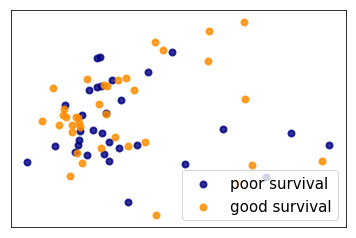

In [21]:
visualise_reduced(X, y, PCA(n_components=2), filename="pca_means_random_sampling_mse.pdf")

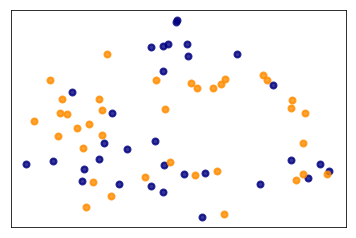

In [24]:
visualise_reduced(X, y, TSNE(n_components=2, random_state=0), filename="tsne_means_random_sampling_mse.pdf", legend=False)

There are no clear visible clusters in the data. Moreover, seperation between poor and good survival is also not very clear although TSNE reduction shows some seperation of the two classes.

### Tile embeddings

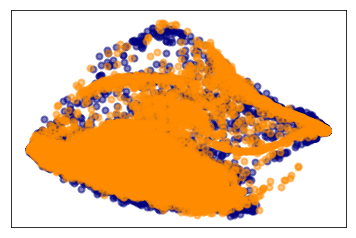

In [25]:
visualise_reduced(X_train_full, y_train_full, PCA(n_components=2), alpha=0.5, filename="pca_all_random_sampling.pdf", legend=False)

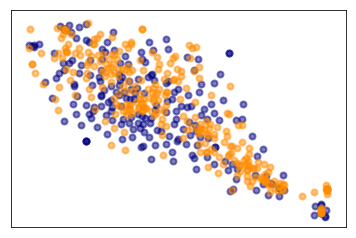

In [26]:
rng = np.random.RandomState(0)
subset = rng.choice(len(X_train_full), 500)
visualise_reduced(X_train_full.iloc[subset], y_train_full[subset], TSNE(n_components=2, random_state=0), alpha=0.5, filename="tsne_all_500_random_sampling.pdf", legend=False)

Looking at the embeddings per tile and not per patient also does not reveal any cluster or any strong seperation.

## Autoencoder reconstruction

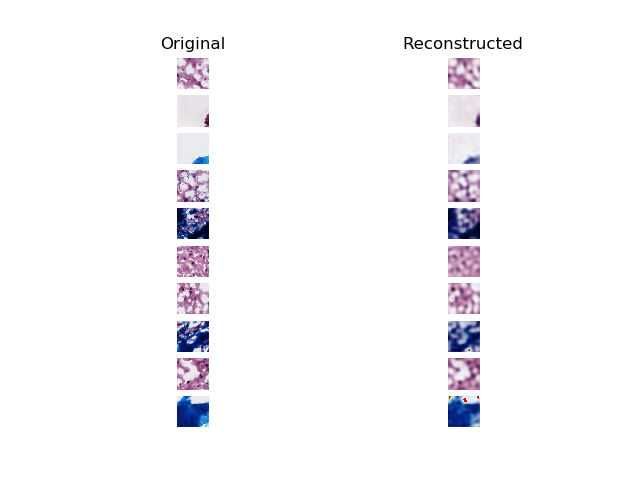

In [32]:
Image("/Users/Tim/data/tcga_gbm/stratified_all_non_background_random_crop_20190125-164121/samples.png")

The autoencoder seems to have learned to reconstruct the basic features of the image. However, the reconstructed images are noticeably blurrier.  

## Most discriminative tiles

To create the following images we extracted the coefficients from the LDA classifier and then looked at what tiles maximise the value of the dimension with the highest coefficient. The top 10 tiles of this dimension are displayed below.

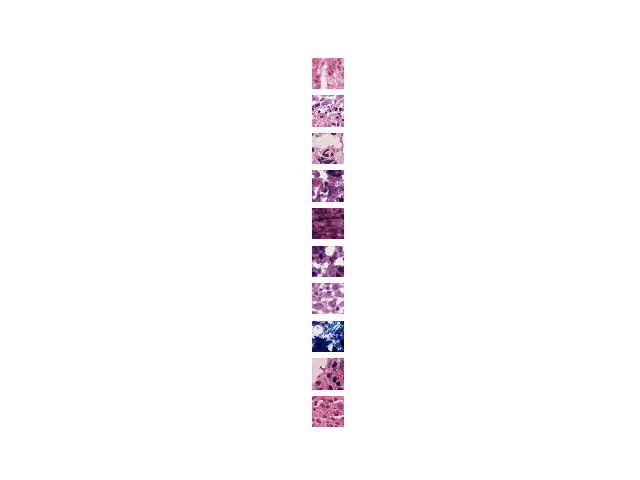

In [41]:
Image("/Users/Tim/data/tcga_gbm/stratified_all_non_background_random_crop_20190125-164121/coef_samples.png")

To me it does not look like these slides have anything in common. Possibly there is a bug in my code but given the weak performance of the classifiers I would first work on improving the feature extraction.

## Conclusion

While our autoencoder seems to learn to reconstruct the images in the training set it does not seem to produce features which are useful for classification. It will be interesting to see whether stain normalization will help in this regard.

Therefore, our next step should be to incorporate the survival information into the training process of the autoencoder. I see two relatively straightforward ways to do this:

1. Currently the loss function of the autoencoder only tries to minimize the euclidean distance between the original and the reconstructed image. We can alter the loss function such that it tries to minimize the distance between the embeddings of the same survival class while maximizing the distance between the different survival classes.

2. We could use an adversial autoencoder. This autoencoder tries to learn to classify between the different survival classes based on the embeddings while trying to learn a good autoencoder. So it could be seen as simultaneously learning the autoencoder and the classifier.

Furthermore, it will be interesting to see if stain normalization will help to improve our performance scores.

# Inter MSE Loss

In [27]:
EMB_PATH = os.path.join(ROOT_DIR, "logs", "inter_mse_loss_20190201-185759", "agg_embeddings.pickle")

In [28]:
X_train, y_train = create_X_y(EMB_PATH, "train")
X_val, y_val = create_X_y(EMB_PATH, "val")
X_test, y_test = create_X_y(EMB_PATH, "test")
X, y = pd.concat([X_train, X_val]), np.concatenate([y_train, y_val])

## Predict poor/good survival

In [29]:
run_classifier(X, y, X_test, y_test, LogisticRegression(random_state=0, solver='lbfgs'), "Logistic Regression")

Logistic Regression:
Training set accuracy: 53.62 %
Test set accuracy: 55.56 %


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [30]:
run_classifier(X, y, X_test, y_test, RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0), "Random Forest")

Random Forest:
Training set accuracy: 69.57 %
Test set accuracy: 50.00 %


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [31]:
lda = run_classifier(X, y, X_test, y_test, LinearDiscriminantAnalysis(solver="svd"), "Linear Discriminant Analysis")

Linear Discriminant Analysis:
Training set accuracy: 60.87 %
Test set accuracy: 44.44 %


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


## Visualisation

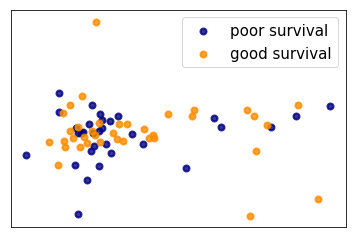

In [32]:
visualise_reduced(X, y, PCA(n_components=2), filename="pca_means_random_sampling_inter.pdf")

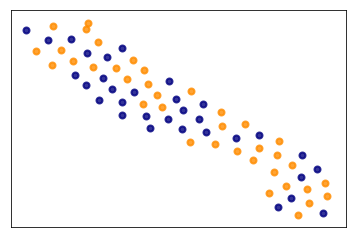

In [33]:
visualise_reduced(X, y, TSNE(n_components=2, random_state=0), filename="tsne_means_random_sampling_inter.pdf", legend=False)

# Right Training data

In [11]:
METADATA_PATH = os.path.join(ROOT_DIR, "metadata", "mean_rgb_non_black", "all_metadata_mean_rgb_non_black.csv")
TRAIN_EMB_PATH = os.path.join(ROOT_DIR, "logs", "cae_correct_data_augmentation_20190307-202857", "train_embeddings.pickle")
VAL_EMB_PATH = os.path.join(ROOT_DIR, "logs", "cae_correct_data_augmentation_20190307-202857", "val_embeddings.pickle")
TEST_EMB_PATH = os.path.join(ROOT_DIR, "logs", "cae_correct_data_augmentation_20190307-202857", "test_embeddings.pickle")
AGG_EMB_PATH = os.path.join(ROOT_DIR, "logs", "cae_correct_data_augmentation_20190307-202857", "agg_embeddings.pickle")

In [12]:
with open(TRAIN_EMB_PATH, "rb") as f:
    train_emb = pickle.load(f)

with open(VAL_EMB_PATH, "rb") as f:
    val_emb = pickle.load(f)

with open(TEST_EMB_PATH, "rb") as f:
    test_emb = pickle.load(f)

with open(AGG_EMB_PATH, "wb") as f:
    pickle.dump({
        "train": train_emb,
        "val": val_emb,
        "test": test_emb
    }, f)

In [13]:
X_train, y_train = create_X_y(AGG_EMB_PATH, "train")
X_val, y_val = create_X_y(AGG_EMB_PATH, "val")
X_test, y_test = create_X_y(AGG_EMB_PATH, "test")
X, y = pd.concat([X_train, X_val]), np.concatenate([y_train, y_val])

In [19]:
run_classifier(X, y, X_test, y_test, LogisticRegression(random_state=0, solver='lbfgs'), "Logistic Regression")

Logistic Regression:
Training set accuracy: 63.77 %
Test set accuracy: 29.41 %


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [20]:
run_classifier(X, y, X_test, y_test, RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0), "Random Forest")

Random Forest:
Training set accuracy: 86.96 %
Test set accuracy: 41.18 %


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [24]:
lda = run_classifier(X, y, X_test, y_test, LinearDiscriminantAnalysis(), "Linear Discriminant Analysis")

Linear Discriminant Analysis:
Training set accuracy: 98.55 %
Test set accuracy: 47.06 %


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


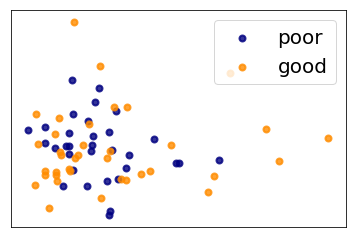

In [17]:
visualise_reduced(X, y, PCA(n_components=2), filename="cae_pca.pdf")

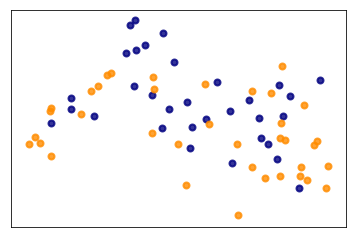

In [18]:
visualise_reduced(X, y, TSNE(n_components=2, random_state=0), legend=False, filename="cae_tsne.pdf")